### Código + **Relatório**

**Aluno:** Savio Augusto Machado Araujo

Este notebook Python contém o código implementado juntamente do relatório, seguindo o padrão que cada célula de Markdown (como essa) refere-se diretamente à célula de código Python seguinte e seus resultados pós-execução, quando aplicável.

Para a execução deste trabalho, foi utilizada a biblioteca Keras para a implementação dos modelos VAE; os dados usados nos treinamentos são disponibilizados diretamente pela biblioteca SKLearn.

---
### Dataset 1 - **make_circles**

O primeiro dataset consiste nos dados sintéticos gerados pela função `make_circles`, assim foram gerados 5000 `samples` distribuídos em duas classes cujas formas tomadas são dois círculos cocêntricos (um para cada classe). A imagem plotada apresenta a distribuição dos dados, com separação das duas classes por cores. Os dados gerados sob esse formato apresentam duas classes bem separadas, sem *outliers* extremos e uma boa organização geral.

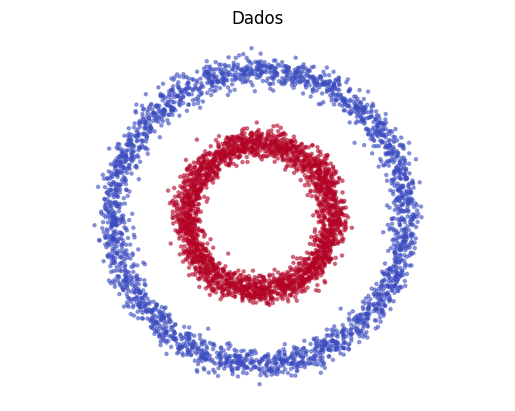

In [1]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=5000, noise=0.05, factor=0.5)
X = X.astype("float32")

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=5, alpha=0.5)
plt.title('Dados')
plt.axis('equal')
plt.axis('off')
plt.show()

Foram treinados 25 modelos para uma mesma arquitetura de rede, dado que o espaço latente gerado pode variar em sua forma ainda que mantenha a geração de espaços análogos. Ainda, considerando que os dados de entrada possuem apenas 2 dimensões (tal qual o espaço latente), é esperado que as representações latentes geradas remetam à forma original com dois círculos cocêntricos, ainda que com diversas distorções oriundas principalmente da adição da divergência KL e aproximação de uma distribuição normal.

A arquitetura escolhida conta com 3 camadas para o `encoder` com 16, 8 e 4 neurônios respectivamente e o mesmo para o `decoder`, porém com a contagem inversa de neurônios. A dimensão do espaço latente foi definida como 2.

---

A função de perda de recontrução usada foi Binary Cross-Entropy, que somada com a divergência KL forma a função de perda total. É importante citar que dadas as limitações de interação entre tensores do backend do `keras` e do `tensorflow`, foi necessário implementar uma camada extra para adicionar a função de perda. 

Foi utilizado o otimizador Adam e cada modelo foi treinado por 30 épocas com *batches* de 64; para os dados, divisão 80:20 entre treino e validação. Vale notar que dado o uso da Binary Cross-Entropy junto da divergência KL, as perdas se apresentaram negativas em alguns casos.

In [ ]:
input_dim = X.shape[1]
latent_dim = 2

encoders = []
decoders = []
vaes = []
losses = []

for i in range(25):
    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(16, activation='tanh')(inputs)
    h = Dense(8, activation='tanh')(h)
    h = Dense(4, activation='tanh')(h)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Função de amostragem
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    decoder_h = Dense(4, activation='tanh')(latent_inputs)
    decoder_h = Dense(8, activation='tanh')(decoder_h)
    decoder_h = Dense(16, activation='tanh')(decoder_h)
    outputs = Dense(input_dim, activation='sigmoid')(decoder_h)

    # Modelos
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(latent_inputs, outputs, name='decoder')
    vae_outputs = decoder(encoder(inputs)[2])

    class VAELossLayer(Layer):
        def call(self, inputs):
            x, x_decoded_mean, z_mean, z_log_var = inputs
            reconstruction_loss = K.mean(binary_crossentropy(x, x_decoded_mean), axis=-1)
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            total_loss = K.mean(reconstruction_loss + kl_loss)
            self.add_loss(total_loss)
            return x_decoded_mean

    vae_outputs = VAELossLayer()([inputs, vae_outputs, z_mean, z_log_var])
    vae = Model(inputs, vae_outputs, name='vae')

    vae.compile(optimizer=Adam(learning_rate=0.0001))
    vae.fit(X, X, epochs=30, batch_size=64, validation_split=0.2)
    
    vaes.append(vae)
    encoders.append(encoder)
    decoders.append(decoder)
    losses.append(vae.history.history['val_loss'][-1])


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.8045 - val_loss: 0.7607
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7358 - val_loss: 0.7035
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6932 - val_loss: 0.6616
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6514 - val_loss: 0.6328
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6225 - val_loss: 0.5961
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5928 - val_loss: 0.5715
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5661 - val_loss: 0.5357
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5334 - val_loss: 0.5105
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5015 - val_loss: 0.4775
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4635 - val_loss: 0.4473
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4321 - val_loss: 0.4136
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3971 - val_lo

A seguir são plotados os espaços latentes `z` gerados por cada modelo a partir da predição do `encoder` dos dados `X`. Dada a natureza dos dados originais e os resultados observados, pode-se avaliar a formação de clusters e a separação dos rótulos de forma conjunta, dado que um cluster sempre representa uma classe para todos os resultados com formação de clusters.

---

Sendo assim, em modelos como o 1, 11 e 18 pode-se observar que a forma geral dos dados de entrada foi bem preservada apesar das distorções, mantendo a distribuição geral em formas elípticas e separando as classes. Há uma separação melhor nos modelos 1 e 11 e uma separação marginal no 18. Modelos como o 10, 15 e 20 tiveram resultados similares em termos de formação de clusters e separação dos rótulos, ainda que as margens entre clusters sejam menores, resultado também do "estreitamento" dos círculos originais o que distorceu mais suas formas.

Também é possível observar muito comumente que diversos modelos "esticaram" a representação latente a ponto de formar "cabos" com os círculos originais; no geral, nesses modelos não há formação de clusters e a separação dos rótulos só pode ser confirmada com a plotagem de cores diferentes, pois os dados se apresentam muito próximos ao tentar fechar o espaço em branco entre os clusters originais. Modelos como o 5, 7 e 12 tornam os dados praticamente indistinguíveis sem rótulos; já modelos como o 24 e 25 ainda permitem um pouco melhor a visualização da separação dos rótulos, ainda que os clusters estejam "colados".

Ainda, há comportamentos como dos modelos 4, 6 e 21 onde as distorções em dimensões superiores trouxeram mais de seu efeito para a representação 2D, sendo que o modelo 21 é o resultado que mais entrelaçou os círculos da distribuição original; nestes, fica ainda mais difícil formar clusters em um espaço de apenas duas dimensões.

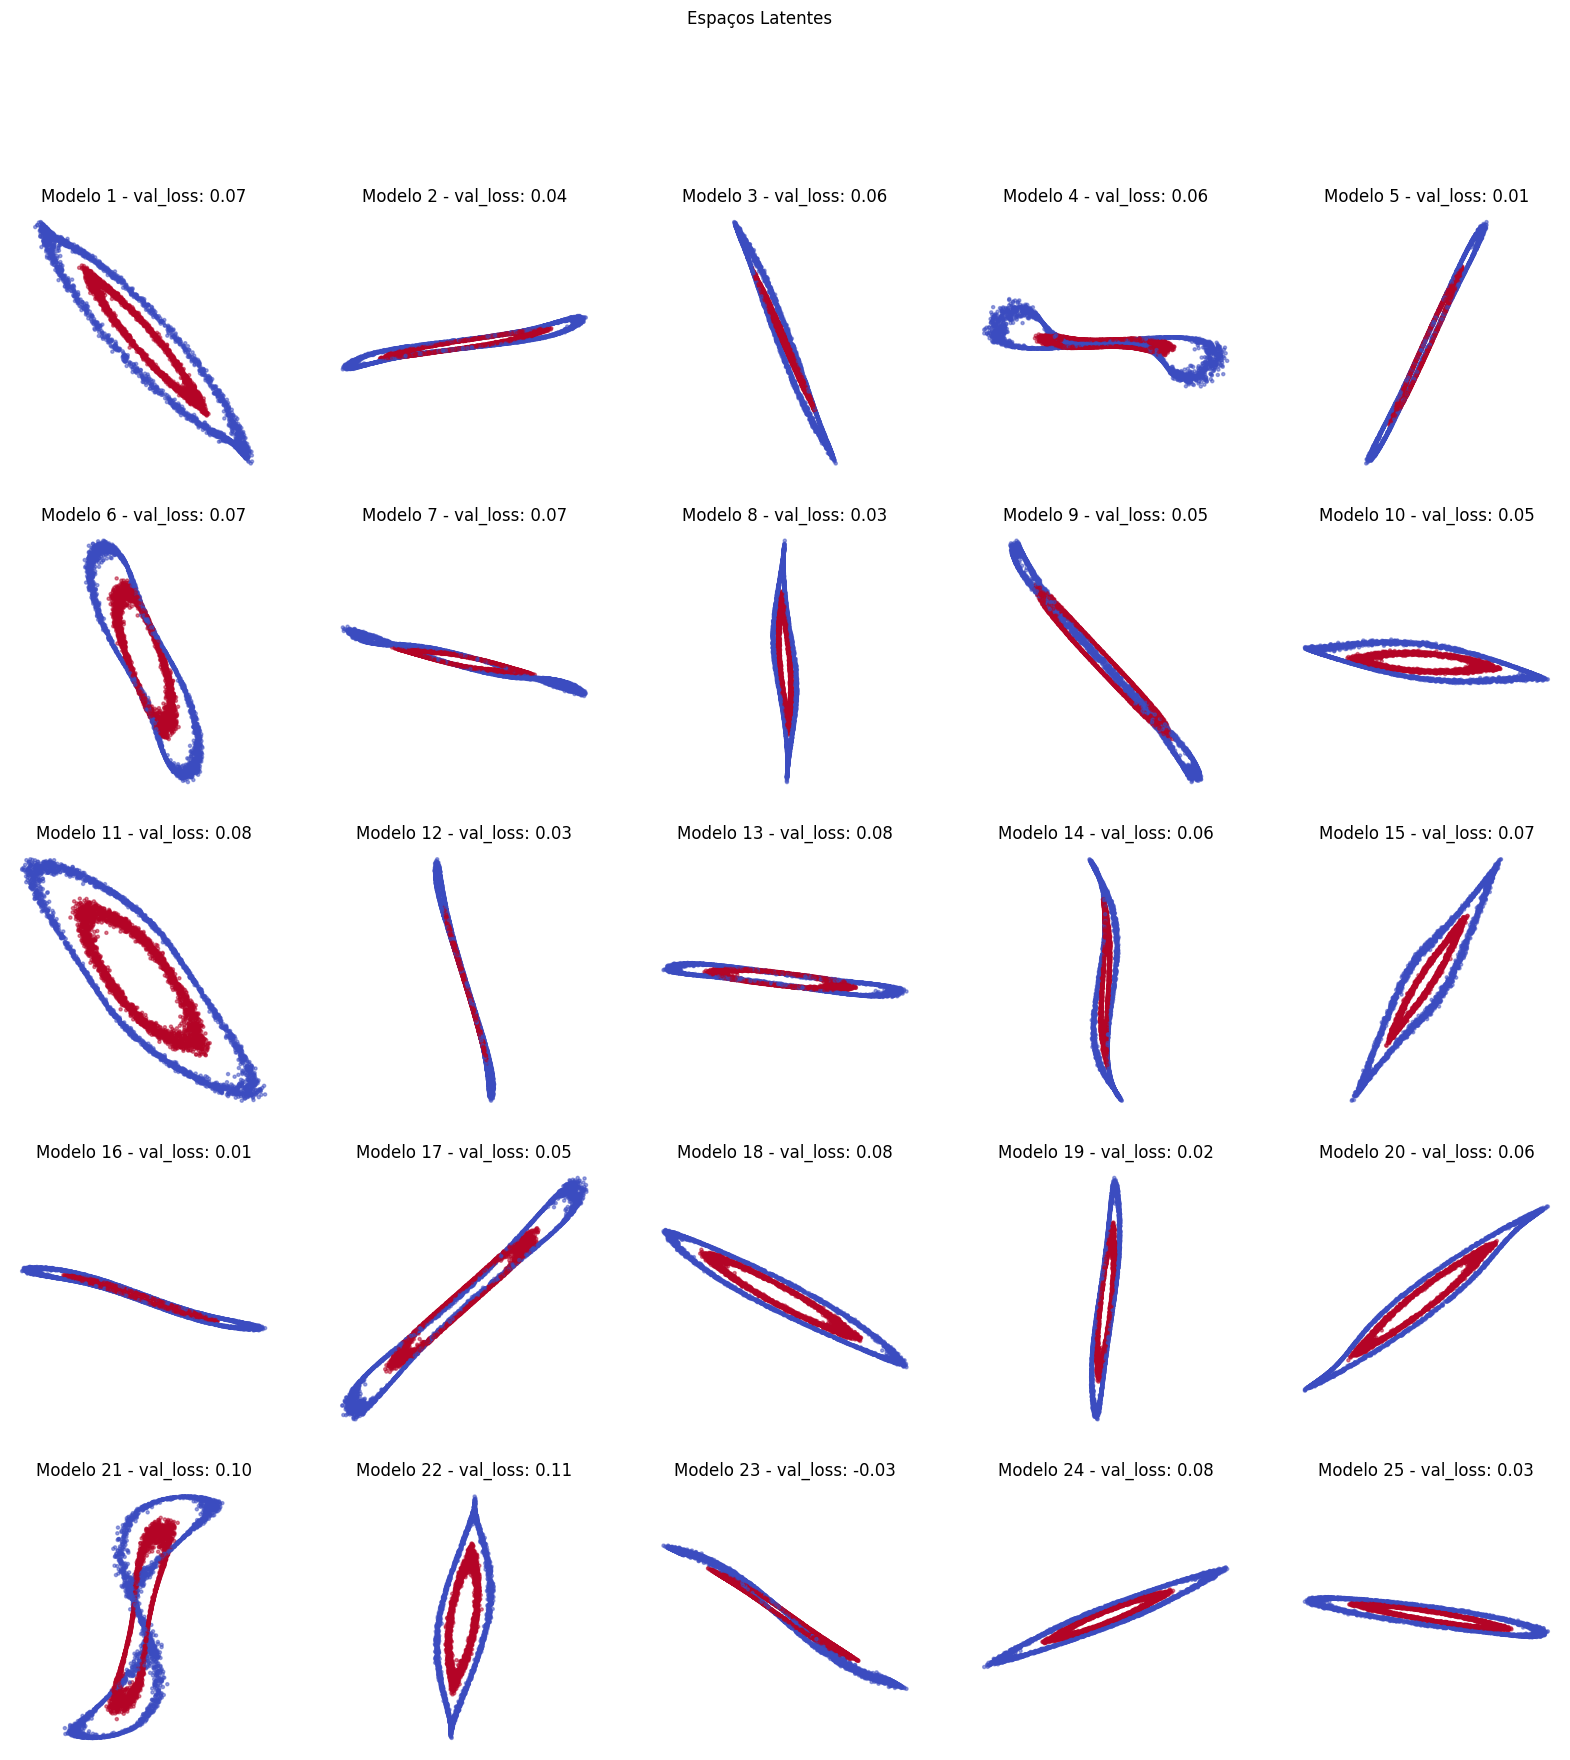

In [5]:
plt.figure(figsize=(20,20))
plt.suptitle("Espaços Latentes")

for i, encoder in zip(range(1, 26), encoders):
    z_mean,_,_ = encoder.predict(X, verbose=0)
    plt.subplot(5, 5, i)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, cmap='coolwarm', s=5, alpha=0.5)
    plt.title(f'Modelo {i} - val_loss: {losses[i-1]:.2f}')
    plt.axis('equal')
    plt.axis('off')

plt.show()

### Dataset 2 - **make_classification**

O segundo dataset consiste também em dados sintéticos, dessa vez gerados e rotulados pela função `make_classification`. Novamente, foram gerados 5000 `samples` distribuídos em 6 classes, cada classe com 1 cluster. Dada a natureza 6-dimensional dos dados, foi aplicado PCA para visualização 2D. É possível observar pela plotagem colorida que há a presença de *outliers* bem mais extremos se comparado ao dataset anterior, visto que há pontos singulares muito longe de seus clusters e, dada a projeção do PCA, comumente dentro de clusters de outras classes.

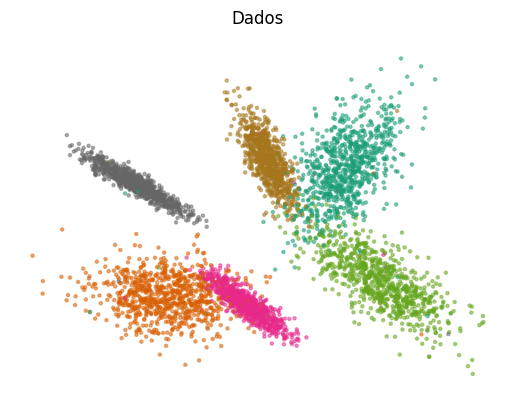

In [89]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

X, y = make_classification(n_samples=5000, n_classes=6, n_features=6, n_informative=3, n_redundant=3, n_clusters_per_class=1, class_sep=2.5)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Dark2', s=5, alpha=0.5)
plt.title('Dados')
plt.axis('equal')
plt.axis('off')
plt.show()


Seguindo o mesmo método anterior, foram treinados 25 modelos sob a mesma arquitetura de rede. Dessa vez, dada a natureza mais aleatória da distribuição dos dados e sua maior dimensionalidade, espera-se que os espaços latentes gerados sejam muito mais variados entre si se comparados aos resultados do dataset anterior.

A arquitetura escolhida conta com 3 camadas para o `encoder` com 16, 8 e 4 neurônios respectivamente e o mesmo para o `decoder`, porém com a contagem inversa de neurônios. A dimensão do espaço latente foi definida como 2. Foi utilizada a mesma função de perda embalada em uma camada do `keras`. Cada modelo foi treinado por 20 épocas com *batches* de 64; para os dados, mesma divisão 80:20 entre treino e validação.

In [90]:
input_dim = X.shape[1]
latent_dim = 2

encoders = []
decoders = []
vaes = []
losses = []

for i in range(25):
    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(16, activation='tanh')(inputs)
    h = Dense(8, activation='tanh')(h)
    h = Dense(4, activation='tanh')(h)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Função de amostragem
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    decoder_h = Dense(4, activation='tanh')(latent_inputs)
    decoder_h = Dense(8, activation='tanh')(decoder_h)
    decoder_h = Dense(16, activation='tanh')(decoder_h)
    outputs = Dense(input_dim, activation='sigmoid')(decoder_h)

    # Modelos
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(latent_inputs, outputs, name='decoder')
    vae_outputs = decoder(encoder(inputs)[2])

    class VAELossLayer(Layer):
        def call(self, inputs):
            x, x_decoded_mean, z_mean, z_log_var = inputs
            reconstruction_loss = K.mean(binary_crossentropy(x, x_decoded_mean), axis=-1)
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            total_loss = K.mean(reconstruction_loss + kl_loss)
            self.add_loss(total_loss)
            return x_decoded_mean

    vae_outputs = VAELossLayer()([inputs, vae_outputs, z_mean, z_log_var])
    vae = Model(inputs, vae_outputs, name='vae')

    vae.compile(optimizer=Adam(learning_rate=0.0001))
    vae.fit(X, X, epochs=20, batch_size=64, validation_split=0.2)
    
    vaes.append(vae)
    encoders.append(encoder)
    decoders.append(decoder)
    losses.append(vae.history.history['val_loss'][-1])


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3849 - val_loss: 2.0965
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0225 - val_loss: 1.7438
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6773 - val_loss: 1.4970
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4201 - val_loss: 1.2674
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2126 - val_loss: 1.0849
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0244 - val_loss: 0.9455
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9143 - val_loss: 0.8451
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7999 - val_loss: 0.7522
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7291 - val_loss: 0.6478
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6470 - val_loss: 0.5922
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5703 - val_loss: 0.5109
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4937 - val_lo

A seguir são plotados os espaços latentes `z` gerados por cada modelo a partir da predição do `encoder` dos dados `X`. Pode-se observar no geral uma variação muito maior da representação latente 2D entre os modelos.

---

Quanto à formação de clusters e separação dos rótulos, vê-se novamente que os resultados que foram mais "espaguetificados" sofrem dos mesmos fatores verificados anteriormente: indistinguibilidade dos clusters originais sem rótulos. Porém, é possível observar vários modelos que aglutinaram os dados em dois grandes clusters com uma ponte de baixa densidade entre eles, como os modelos 10, 19 e 20. Nesses, com o há menos clusters que classes, obviamente há mais de uma classe aglutinada em um cluster, sendo assim a formação de clusters não necessariamente refletiu numa boa separação dos rótulos.

Alguns modelos geraram ainda mais clusters, como é o caso dos modelos 7, 12 e 18; nesses, especialmente no modelo 7, é possível distinguir bem os 6 rótulos pois cad aum possui seu pseudocluster próprio, ainda que sejam clusters ligados por "pontes" de baixa densidade de dados; justamente a diferença na densidade é o que possiblita a distinção. Além disso, modelos como o 10, 20 e 23, apesar de não trazerem necessariamente uma formação de clusters considerável, adotaram uma forma de "anel" no espaço latente a fim de aglutinar os dados ao mesmo tempo em que forma as "pontes" para tornar o espaço mais navegável.

Ainda, em modelos como o 5, 8 e 11 pode-se observar que,  apesar da ausência de clusters bem definidos, a separação dos rótulos foi muito mais efeitva para algumas classes do que para outras; os rótulos dispostos mais nas "pontas" da forma se paresentam muito mais aglutinados (mas não necessariamente separáveis), enquanto mais no centro os dados se dispersam muito mais pelo espaço apesar de possuírem um mesmo rótulo.

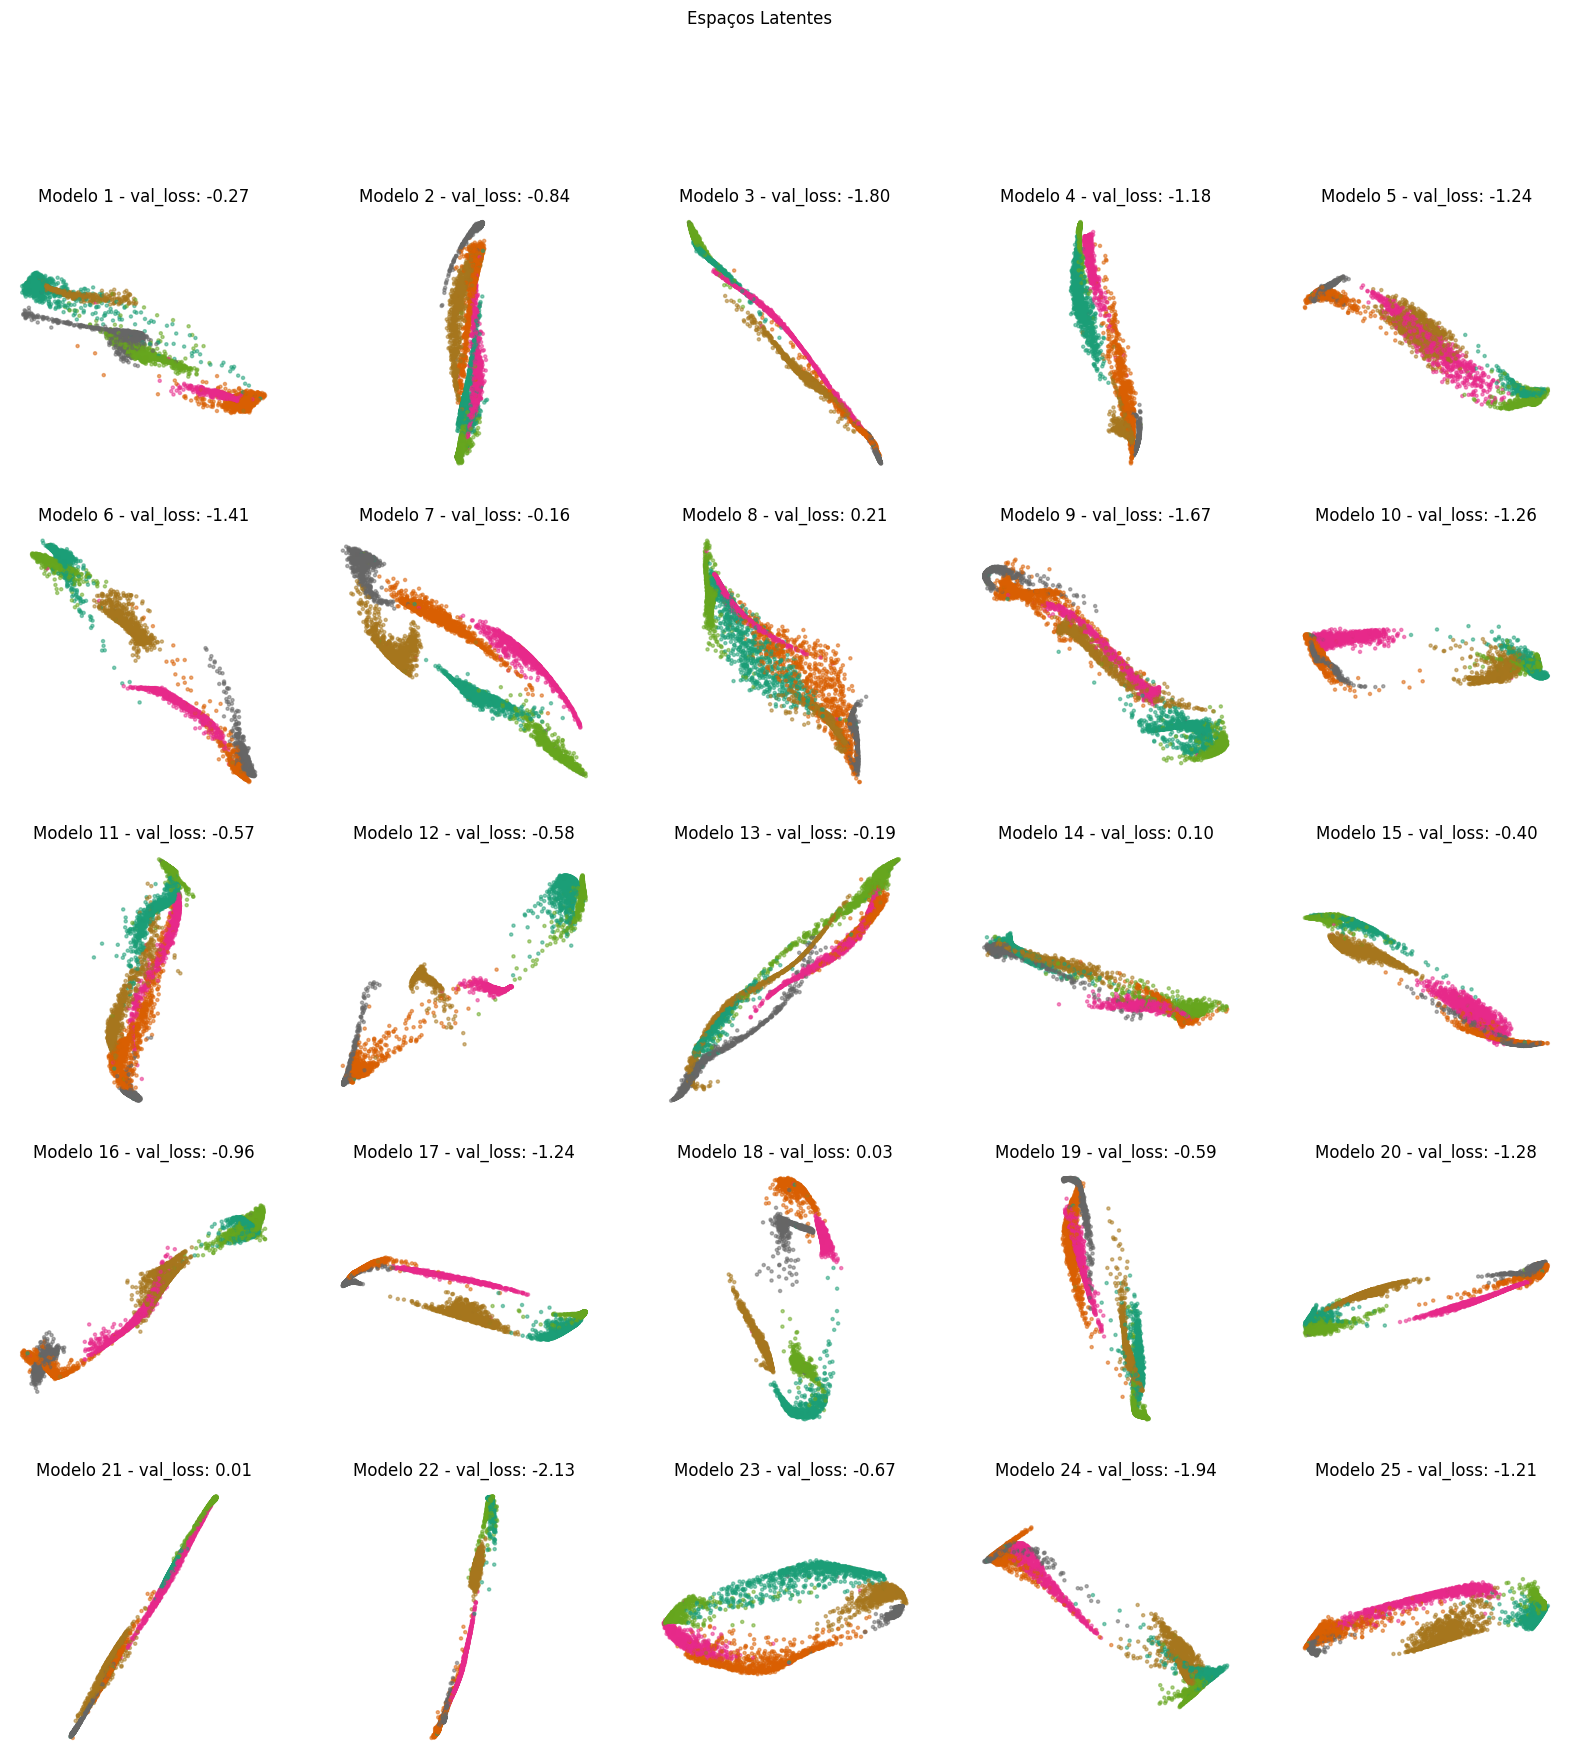

In [91]:
plt.figure(figsize=(20,20))
plt.suptitle("Espaços Latentes")

for i, encoder in zip(range(1, 26), encoders):
    z_mean,_,_ = encoder.predict(X, verbose=0)
    plt.subplot(5, 5, i)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, cmap='Dark2', s=5, alpha=0.5)
    plt.title(f'Modelo {i} - val_loss: {losses[i-1]:.2f}')
    plt.axis('equal')
    plt.axis('off')

plt.show()